In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime  
from datetime import timedelta  

In [2]:
# Load Tensor
with open('../pkl/COVID_sorted_W_tensors_ver2.pkl', 'rb') as f:
    travel_data = pickle.load(f)

In [3]:
travel_data.shape

(22, 54, 108)

In [4]:
week_slices = pd.date_range('2020-01-19', periods=23, freq='W')
xaxis = week_slices[1:]

In [5]:
df = pd.read_csv("PatientInfo.csv")
df['confirmed_date'] = pd.to_datetime(df['confirmed_date'])
df = df[df['province'].isin(["Seoul", "Gyeonggi-do", "Incheon"])]

In [6]:
confdate = df['confirmed_date']
# confdate.groupby().count()

In [7]:
datecount = []

In [8]:
for x in xaxis:
    cnt=0
    for date in confdate:
        if((date<x) & (date> x-timedelta(days=7))):
            cnt=cnt+1
    datecount.append(cnt)
datecount = np.array(datecount)

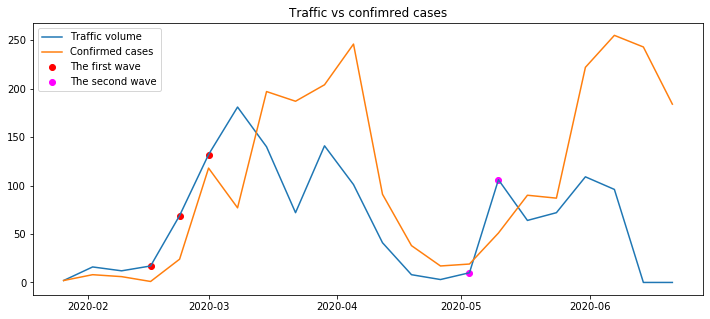

In [9]:
# travel_data.shape
tensors = travel_data[:,:,:54]
traffic = np.sum(np.sum(tensors, 2),1) # total traffic
# outtraffic = np.sum(np.sum(tensors, 1),1)
# traffic = intraffic +outtraffic

plt.figure(figsize=(12,5))
plt.plot(xaxis, traffic, label= 'Traffic volume')
plt.plot(xaxis, datecount, label = 'Confirmed cases')
plt.scatter(xaxis[3:6], traffic[3:6], color='red', label = 'The first wave')
plt.scatter(xaxis[-8:-6], traffic[-8:-6], color='magenta', label = 'The second wave')
plt.title("Traffic vs confimred cases")
plt.legend()

In [10]:
np.corrcoef([traffic[:-1], datecount[1:]])

array([[1.        , 0.66161707],
       [0.66161707, 1.        ]])

In [11]:
with open('../pkl/COVID_label_dict.pkl', 'rb') as f:
    label_dict = pickle.load(f)

In [12]:
time = -7
for i in range(54):
    node = i
    intraffic = np.sum(tensors[time,:,node])- np.sum(tensors[time-1,:,node]) #in-traffic
    outtraffic = np.sum(tensors[time,node,:])- np.sum(tensors[time-1,node,:]) #out-traffic
#     if(intraffic >0):
#         print(i,label_dict[node],outtraffic)
#         print(i,label_dict[node],intraffic+outtraffic)

In [13]:
time = 5
for i in range(54):
    node = i
    outtraffic = np.sum(tensors[time,node,:])- np.sum(tensors[time-1,node,:]) #out-traffic
    if(outtraffic >4):
        print(i,label_dict[node],outtraffic)

3 Guro-gu 5.0
8 Gangseo-gu 6.0
10 Dongdaemun-gu 6.0
13 Geumcheon-gu 5.0
17 Gangbuk-gu 5.0


In [14]:
pop = pd.read_csv("./SeoulFloating.csv")
pop.date=pd.to_datetime(pop.date)

In [15]:
monday = pd.date_range('2020-01-06', periods=22, freq='7D')
tueday = pd.date_range('2020-01-07', periods=22, freq='7D')
wedday = pd.date_range('2020-01-08', periods=22, freq='7D')
thuday = pd.date_range('2020-01-09', periods=22, freq='7D')
friday = pd.date_range('2020-01-10', periods=22, freq='7D')
satday = pd.date_range('2020-01-11', periods=22, freq='7D')
sunday = pd.date_range('2020-01-12', periods=21, freq='7D')

In [16]:
sunday

DatetimeIndex(['2020-01-12', '2020-01-19', '2020-01-26', '2020-02-02',
               '2020-02-09', '2020-02-16', '2020-02-23', '2020-03-01',
               '2020-03-08', '2020-03-15', '2020-03-22', '2020-03-29',
               '2020-04-05', '2020-04-12', '2020-04-19', '2020-04-26',
               '2020-05-03', '2020-05-10', '2020-05-17', '2020-05-24',
               '2020-05-31'],
              dtype='datetime64[ns]', freq='7D')

In [17]:
pop[pop['city']=='Guro-gu']

,date,hour,birth_year,sex,province,city,fp_num
18,2020-01-01,0,20,female,Seoul,Guro-gu,26040
19,2020-01-01,0,20,male,Seoul,Guro-gu,27080
68,2020-01-01,1,20,female,Seoul,Guro-gu,26130
69,2020-01-01,1,20,male,Seoul,Guro-gu,27040
118,2020-01-01,2,20,female,Seoul,Guro-gu,26060
...,...,...,...,...,...,...,...
1084695,2020-05-30,9,60,female,Seoul,Guro-gu,23190
1084710,2020-05-30,15,20,male,Seoul,Guro-gu,26890
1084726,2020-05-30,20,30,female,Seoul,Guro-gu,34080
1084743,2020-05-31,2,70,male,Seoul,Guro-gu,13570


In [18]:
def node_float_pop(nodename):
    if(nodename=='Dongjak-gu'):
        nodename = 'Dongjag-gu'
    node_pop = pop[pop['city']==nodename]
    node_pop = node_pop[np.invert(node_pop['date'].isin(thuday))]
    fp_list = []
    for d in sunday:
        condition = (node_pop['date']< d) & (node_pop['date'] >= d - timedelta(days=7))
        filtered_pop = node_pop[condition]
        fpsum = filtered_pop['fp_num'].sum()
        if(fpsum>0):
            fp_list.append(fpsum)
        else:
            fp_list.append(fp_list[-1])
    return np.array(fp_list)

In [19]:
def node_confirmed_case(node_name):
    node_confdate = df[df['city']==node_name]['confirmed_date']
    datecount = []
    for x in xaxis:
        cnt=0
        for date in node_confdate:
            if((date<x) & (date>= x-timedelta(days=7))):
                cnt=cnt+1
        datecount.append(cnt)
    datecount = np.array(datecount)
    return datecount

In [20]:
tensors = travel_data[:,:54,:54]
tensors.shape

(22, 54, 54)

In [21]:
def node_patient_traffic(node_num):
    cnt_num = node_num
    intraffic = np.sum(tensors[:,:,cnt_num], 1) #in-traffic
    outtraffic = np.sum(tensors[:,cnt_num,:], 1) #outtraffic
    return intraffic + outtraffic

In [22]:
node_float_pop('Guro-gu')[-18:]

array([50645840, 51343290, 50764830, 50785650, 59377090, 51826450,
       49444710, 50424460, 50299480, 50635440, 50679040, 50479580,
       50571610, 49139520, 50242490, 51176260, 50828180, 48036340])

In [23]:
node_patient_traffic(3)[:-3]

array([ 0.,  0.,  0.,  0.,  5., 15., 74., 26., 26.,  1.,  2.,  0.,  0.,
        0.,  0.,  5.,  5.,  3.,  2.])

In [24]:
node_confirmed_case('Guro-gu')[:-3]

array([ 0,  0,  0,  0,  1,  0,  0, 17,  5,  6,  5,  0,  0,  0,  0,  0,  0,
        1,  5])

In [25]:
# nodenum = 5
def three_plots_corr(nodenum):
    fig, axs = plt.subplots(3,figsize=(12,8))
    
    nodename = label_dict[nodenum]
    fig.suptitle(nodename, fontsize=20)

    flopop = node_float_pop(nodename)[-19:] * 100/41.8
    pait = node_patient_traffic(nodenum)[:-3]
    conf = node_confirmed_case(nodename)[:-3]

    axs[0].plot(xaxis[:-3], flopop, label = 'floating population')
    axs[1].plot(xaxis[:-3], pait, label = 'patient traffic')
    axs[2].plot(xaxis[:-3], conf, label = 'confirmed cases')
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    print(np.corrcoef([flopop[:-1], pait[1:]]))
    print(np.corrcoef([pait[1:-1], conf[2:]]))

In [52]:
week_slices

DatetimeIndex(['2020-01-19', '2020-01-26', '2020-02-02', '2020-02-09',
               '2020-02-16', '2020-02-23', '2020-03-01', '2020-03-08',
               '2020-03-15', '2020-03-22', '2020-03-29', '2020-04-05',
               '2020-04-12', '2020-04-19', '2020-04-26', '2020-05-03',
               '2020-05-10', '2020-05-17', '2020-05-24', '2020-05-31',
               '2020-06-07', '2020-06-14', '2020-06-21'],
              dtype='datetime64[ns]', freq='W-SUN')

[[1.         0.46299798]
 [0.46299798 1.        ]]
[[1.         0.75897359]
 [0.75897359 1.        ]]


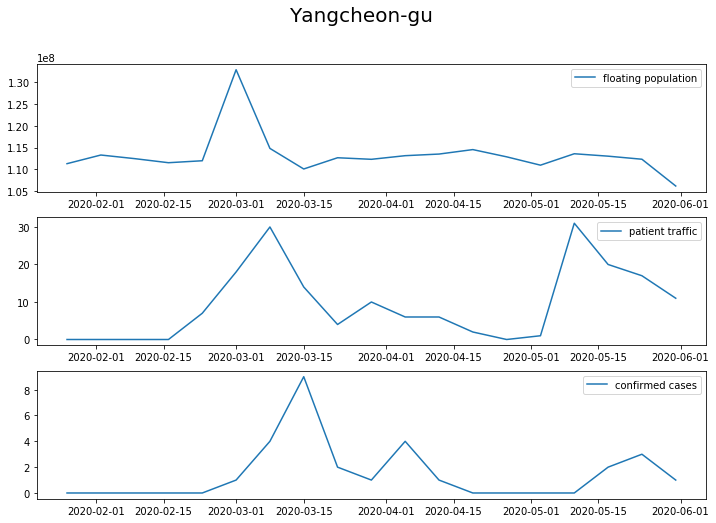

In [56]:
three_plots_corr(2)

In [28]:
def differencing(inputarray):
    diff = list()
    for i in range(len(inputarray)-1):
        value = inputarray[i+1] - inputarray[i]
        diff.append(value)
    return diff

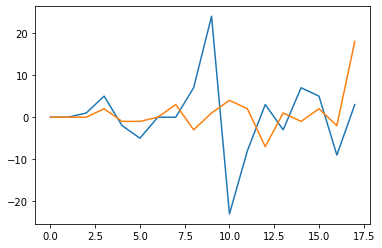

In [29]:
nodenum=12
nodename = label_dict[nodenum]

flopop = differencing(node_float_pop(nodename)[-18:])
pait = differencing(node_patient_traffic(nodenum)[:-3])
conf = differencing(node_confirmed_case(nodename)[:-3])

plt.plot(pait)
plt.plot(conf)


In [30]:
# var1 = 'flopop'
# var2 ='patient'

# granger_df = pd.DataFrame([np.array(flopop), pait, conf]).T
# granger_df.columns = ['flopop','patient','confirmation']
# p1 = augmented_dickey_fuller_statistics(granger_df[var1])
# p2 = augmented_dickey_fuller_statistics(granger_df[var2])

# grangers_causality_matrix(granger_df, variables = [var1, var2])

In [31]:
# granger_df = pd.DataFrame([xaxis[:-3], np.array(flopop), pait, conf]).T
# granger_df.columns = ['date','flopop','patient','confirmation']
# granger_df = granger_df.set_index('date')

In [32]:
# # n_obs=1
# dataset = granger_df
# # X_train, X_test = dataset[0:-n_obs], dataset[-n_obs:]
# X_train = dataset
# print(X_train.shape) #, X_test.shape)

In [33]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
#     print('ADF Statistic: %f' % result[0])
#     print('p-value: %f' % result[1])
#     print('Critical Values:')
#     for key, value in result[4].items():
#         print('\t%s: %.3f' % (key, value))
    return result[1]

In [34]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

In [35]:
# test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
#             print(r,c)
            test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
#             print(test_result)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset

In [36]:
def granger_caus(var1, var2):
    cnt=0
    p_list = []
    #22 25 26 28 
    for nodenum in np.append(np.arange(21),[22,25,26,28]):
        nodename = label_dict[nodenum]
        #
        flopop = differencing(node_float_pop(nodename)[-19:] * 100/41.8) 
        pait = differencing(node_patient_traffic(nodenum)[:-3])
        conf = differencing(node_confirmed_case(nodename)[:-3])
        #
        granger_df = pd.DataFrame([np.array(flopop), pait, conf]).T
        granger_df.columns = ['flopop','patient','confirmation']
        
        p1 = adfuller(granger_df[var1].values, maxlag = maxlag)[1]
        p2 = adfuller(granger_df[var2].values, maxlag = maxlag)[1]
        #
#         print(p1,p2)
        if(p1<0.05):
            if(p2<0.05):
#                 print(nodenum)
                cnt=cnt+1
                var_1to2 = grangers_causality_matrix(granger_df, variables = [var1, var2]).iloc[1,0] # var1->var2
                p_list.append(var_1to2)
    print("cnt",cnt)
    return p_list

In [37]:
def FDR(sorted_array):
    sample_size=len(sorted_array)
    cnt=0
    for i in range(sample_size):
        if(sorted_array[i]< 0.05*(i+1)/(sample_size)):
            cnt+=1
    return(cnt)

In [38]:
maxlag=5

In [39]:
test1 = np.sort(granger_caus('flopop','patient'))
print(test1)
print(FDR(test1))

cnt 25
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0001 0.0016
 0.0036 0.0085 0.0324 0.0421 0.0957]
24


In [40]:
test2 = np.sort(granger_caus('patient','confirmation'))
print(test2)
print(FDR(test2))

cnt 23
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0003 0.0034 0.2527]
22


In [41]:
test3 = np.sort(granger_caus('flopop','confirmation'))
print(test3)
print(FDR(test3))

cnt 23
[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.0003 0.0003
 0.0006 0.0008 0.0021]
23


In [42]:
sample_size=11
for i in range(1,sample_size+1):
    print(0.05*i/sample_size)

0.004545454545454546
0.009090909090909092
0.01363636363636364
0.018181818181818184
0.022727272727272728
0.02727272727272728
0.03181818181818182
0.03636363636363637
0.04090909090909091
0.045454545454545456
0.05


In [43]:
index=0
granger_df =None
for nodenum in np.append(np.arange(21),[22,25,26,28]):
    nodename = label_dict[nodenum]
    #
    flopop = (node_float_pop(nodename)[-19:] * 100/41.8) 
    pait = (node_patient_traffic(nodenum)[:-3])
    conf = (node_confirmed_case(nodename)[:-3])
    #
    temp = pd.DataFrame([range(len(flopop)), np.array(flopop), pait, conf]).T
    temp.columns = ['time','flopop','patient','confirmation']
    temp['index']=index
    #
    if(index==0):
        granger_df=temp
        print(granger_df)
    else:
        granger_df = granger_df.append(temp)
    index = index + 1

    time        flopop  patient  confirmation  index
0    0.0  1.026765e+08      0.0           0.0      0
1    1.0  1.031339e+08      4.0           1.0      0
2    2.0  1.018071e+08      2.0           0.0      0
3    3.0  1.006113e+08      2.0           0.0      0
4    4.0  1.012663e+08      3.0           0.0      0
5    5.0  1.198443e+08      9.0           0.0      0
6    6.0  1.033519e+08     21.0           1.0      0
7    7.0  9.925914e+07     11.0           3.0      0
8    8.0  1.015194e+08      9.0           3.0      0
9    9.0  1.009536e+08     33.0           5.0      0
10  10.0  1.013111e+08     32.0           2.0      0
11  11.0  1.013481e+08      9.0           1.0      0
12  12.0  1.021720e+08      1.0           0.0      0
13  13.0  1.006710e+08      2.0           0.0      0
14  14.0  9.965921e+07      0.0           0.0      0
15  15.0  1.021085e+08      9.0           1.0      0
16  16.0  1.010552e+08      6.0           0.0      0
17  17.0  1.006061e+08     11.0           1.0 

In [44]:
# granger_df.to_csv("paneldata_nondiff.csv", index=False)